<a href="https://colab.research.google.com/github/shanta-2000/Image-Classification-with-Caltech-101-Dataset/blob/main/Lab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=bcedb1ccc12e572c1544cf4cfde8f9c0b64c718a9e2362dba7df5ef7aff8c704
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [39]:
pip install --upgrade grad-cam


In [35]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Step 1: Dataset Extraction and Preparation
# Path to the dataset archive and extraction folder
tar_path = r'/content/drive/MyDrive/CSE366/caltech101/caltech-101/caltech-101/101_ObjectCategories.tar.gz'
extract_path = r'/content/drive/MyDrive/CSE366/caltech101/caltech-101/caltech-101/101_ObjectCategories'

# Extract the dataset
if not os.path.exists(extract_path):
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=os.path.dirname(extract_path))
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Path to the dataset
root_dir = extract_path

Extraction complete.


In [20]:
# Inspect the dataset structure
classes = os.listdir(root_dir)
print(f"Found {len(classes)} classes: {classes[:5]}...")


Found 102 classes: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes']...


In [21]:
# Ensure no unexpected folders are included
if 'BACKGROUND_Google' in classes:
    print("Excluding 'BACKGROUND_Google' class.")
    classes.remove('BACKGROUND_Google')

Excluding 'BACKGROUND_Google' class.


In [22]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
from PIL import Image
import os

for root, _, files in os.walk(root_dir):
    for file in files:
        try:
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                img.verify()  # Verify if it's a valid image
        except Exception as e:
            print(f"Invalid file: {img_path}, Error: {e}")

In [24]:
# Load dataset
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Verify class mappings
print(f"Class-to-index mapping: {dataset.class_to_idx}")

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Class-to-index mapping: {'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_easy': 2, 'Leopards': 3, 'Motorbikes': 4, 'accordion': 5, 'airplanes': 6, 'anchor': 7, 'ant': 8, 'barrel': 9, 'bass': 10, 'beaver': 11, 'binocular': 12, 'bonsai': 13, 'brain': 14, 'brontosaurus': 15, 'buddha': 16, 'butterfly': 17, 'camera': 18, 'cannon': 19, 'car_side': 20, 'ceiling_fan': 21, 'cellphone': 22, 'chair': 23, 'chandelier': 24, 'cougar_body': 25, 'cougar_face': 26, 'crab': 27, 'crayfish': 28, 'crocodile': 29, 'crocodile_head': 30, 'cup': 31, 'dalmatian': 32, 'dollar_bill': 33, 'dolphin': 34, 'dragonfly': 35, 'electric_guitar': 36, 'elephant': 37, 'emu': 38, 'euphonium': 39, 'ewer': 40, 'ferry': 41, 'flamingo': 42, 'flamingo_head': 43, 'garfield': 44, 'gerenuk': 45, 'gramophone': 46, 'grand_piano': 47, 'hawksbill': 48, 'headphone': 49, 'hedgehog': 50, 'helicopter': 51, 'ibis': 52, 'inline_skate': 53, 'joshua_tree': 54, 'kangaroo': 55, 'ketch': 56, 'lamp': 57, 'laptop': 58, 'llama': 59, 'lobster': 60, 'lotus'

In [25]:
# Step 2: Model Selection
# Adjust model for correct number of classes
num_classes = len(dataset.classes)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust for detected classes


In [28]:
# Step 3: Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Processing batch {batch_idx + 1}/{len(train_loader)}")
        try:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        except Exception as e:
            print(f"Skipping problematic batch: {e}")
            continue

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader):.4f}")


Processing batch 1/229
Processing batch 2/229
Processing batch 3/229
Processing batch 4/229
Processing batch 5/229
Processing batch 6/229
Processing batch 7/229
Processing batch 8/229
Processing batch 9/229
Processing batch 10/229
Processing batch 11/229
Processing batch 12/229
Processing batch 13/229
Processing batch 14/229
Processing batch 15/229
Processing batch 16/229
Processing batch 17/229
Processing batch 18/229
Processing batch 19/229
Processing batch 20/229
Processing batch 21/229
Processing batch 22/229
Processing batch 23/229
Processing batch 24/229
Processing batch 25/229
Processing batch 26/229
Processing batch 27/229
Processing batch 28/229
Processing batch 29/229
Processing batch 30/229
Processing batch 31/229
Processing batch 32/229
Processing batch 33/229
Processing batch 34/229
Processing batch 35/229
Processing batch 36/229
Processing batch 37/229
Processing batch 38/229
Processing batch 39/229
Processing batch 40/229
Processing batch 41/229
Processing batch 42/229
P

In [31]:
# Step 4: Validation
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_correct / val_total:.4f}")


Validation Loss: 2.0566, Accuracy: 0.4770


In [30]:
# Step 5: Testing
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred))

Confusion Matrix:
 [[24  0  0 ...  0  0  0]
 [ 0 35  1 ...  0  0  0]
 [ 0  0 47 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.51      0.34        47
           1       1.00      0.92      0.96        38
           2       0.82      1.00      0.90        47
           3       0.72      0.78      0.75        23
           4       0.95      0.97      0.96        75
           5       0.14      0.50      0.22         2
           6       0.96      0.88      0.92        77
           7       0.00      0.00      0.00         5
           8       0.25      0.20      0.22         5
           9       1.00      0.25      0.40         4
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         2
          13       0.50      0.60      0.55 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


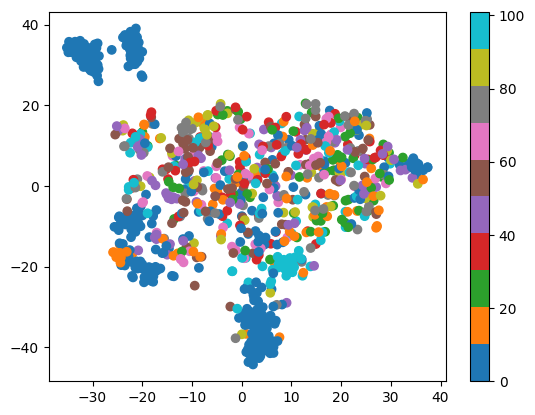

In [32]:
# Step 6: t-SNE Visualization
features = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        features.append(output.cpu())
        labels_list.append(labels)

features = torch.cat(features).numpy()
labels_list = torch.cat(labels_list).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_list, cmap='tab10')
plt.colorbar()
plt.show()


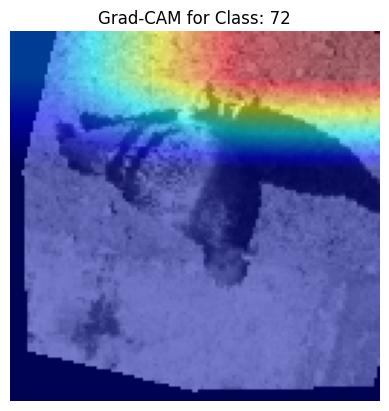

In [43]:
# Step 7: Grad-CAM Visualization
# Fix for GradCAM target layer and arguments
cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

for images, labels in test_loader:
    images = images.to(device)
    targets = [ClassifierOutputTarget(labels[0].item())]

    try:
        # Convert image to numpy array in [0, 1] range for visualization
        input_image = images[0].permute(1, 2, 0).cpu().numpy()
        input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

        grayscale_cam = cam(input_tensor=images, targets=targets)[0]
        cam_image = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)
        plt.imshow(cam_image)
        plt.title(f"Grad-CAM for Class: {labels[0].item()}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error during Grad-CAM generation: {e}")
    break